In [1]:
# checking whether a file exists

import os
file_path = "../input/graphdatasetiitjohdpur/chartsv2/charts/train_val.csv"
print(os.path.exists(file_path))

True


In [2]:
# read the csv file into a dataframe

import pandas as pd
df = pd.read_csv(file_path)
df.head()

,image_index,type
0,0,vbar_categorical
1,1,vbar_categorical
2,2,vbar_categorical
3,3,vbar_categorical
4,4,vbar_categorical


In [3]:
# check for the unique labels in the dataframe

df.type.unique()

array(['vbar_categorical', 'hbar_categorical', 'line', 'pie', 'dot_line'],
      dtype=object)

In [4]:
# fetching the training data

train_dir = "../input/graphdatasetiitjohdpur/chartsv2/charts/train_val"

import os
train_paths = os.listdir(train_dir)
print(len(train_paths))

1000


In [5]:
# storing the images and the labels into an array

import numpy as np
import cv2
def sort_data(dir, data, df):
    images = []
    labels = []
    for i in range(len(data)):
        img = cv2.imread(os.path.join(dir, data[i]))    # reading the images from the directory
        index = int(data[i].split(".")[0])
        label = df.loc[index, 'type']                   # fetching the associated labels
        labels.append(label)
        images.append(img)
    return np.array(images), np.array(labels)

X_train, Y_train = sort_data(train_dir, train_paths, df)

print(X_train.shape)
print(Y_train.shape)

(1000, 128, 128, 3)
(1000,)


Look's like we have 1000 samples so we can go ahead and divide the into 800 for training and 200 for validation

In [6]:
# spliting the dataset into validation and training

from sklearn.model_selection import train_test_split
 
x_train, x_validation, y_train, y_validation = train_test_split(
    X_train, 
    Y_train, 
    test_size=200, 
    shuffle=True,
    random_state=42,
    stratify=Y_train
)

print(x_train.shape)
print(y_train.shape)
print(x_validation.shape)
print(y_validation.shape)

(800, 128, 128, 3)
(800,)
(200, 128, 128, 3)
(200,)


In [7]:
# checking the distribution among all the labels

print(np.unique(y_train, return_counts=True))
print(np.unique(y_validation, return_counts=True))

(array(['dot_line', 'hbar_categorical', 'line', 'pie', 'vbar_categorical'],
      dtype='<U16'), array([160, 160, 160, 160, 160]))
(array(['dot_line', 'hbar_categorical', 'line', 'pie', 'vbar_categorical'],
      dtype='<U16'), array([40, 40, 40, 40, 40]))


In [8]:
# integer encoding 

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train)
y_train_enc = le.transform(y_train)
y_validation_enc = le.transform(y_validation)

print(np.unique(y_train_enc, return_counts=True))
print(np.unique(y_validation_enc, return_counts=True))

(array([0, 1, 2, 3, 4]), array([160, 160, 160, 160, 160]))
(array([0, 1, 2, 3, 4]), array([40, 40, 40, 40, 40]))


Ploting random training data to see if the encoding is done properly and also to visualise images

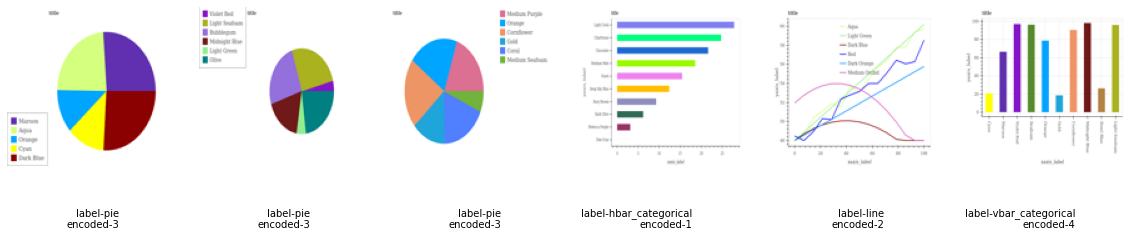

In [9]:
import matplotlib.pyplot as plt
import cv2
n = np.random.randint(0, 800, 6)
plt.figure(figsize=(20, 4))
for i in range(1, len(n)+1): 
    ax = plt.subplot(1, len(n), i)
    img = x_train[n[i-1]]
    plt.imshow(img)
    ax.text(0.7, -0.4, "label-{0}\nencoded-{1}".format(y_train[n[i-1]], y_train_enc[n[i-1]]),
    verticalalignment='bottom', horizontalalignment='right',
    transform=ax.transAxes, fontsize=10)
    plt.axis("off")
plt.show()

In [10]:
print(y_train.shape)
print(y_validation.shape)

(800,)
(200,)


In [11]:
# reading the test data for model predictions

test_dir = "../input/graphdatasetiitjohdpur/chartsv2/charts/test"
test_imgs = os.listdir(test_dir)

x_test = []
for img in test_imgs:
    im = cv2.imread(os.path.join(test_dir, img))
    x_test.append(im)
x_test = np.array(x_test)
print(x_test.shape)

(50, 128, 128, 3)


In [12]:
# enum class helps when we to the prediction to see the associated label against each predicted integer

from enum import Enum
class Number(Enum):
    dot_line = 0
    hbar = 1
    line = 2
    pie = 3
    vbar = 4

In [13]:
# installing aditional library wherein tensorflow transformer implementation is there
!pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.14.0
    Uninstalling tensorflow-addons-0.14.0:
      Successfully uninstalled tensorflow-addons-0.14.0


In [14]:
# MODEL parameters are initialised in one section

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

input_shape = (128, 128, 3)
num_classes = 5

learning_rate = 0.0001
weight_decay = 0.0001
batch_size = 64
num_epochs = 30
image_size = 128  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 512
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size)
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

2022-08-07 11:28:07.027991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 11:28:07.174679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 11:28:07.175514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 11:28:07.177893: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [17]:
# Implementing MLP
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [18]:
# Patch creation Layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 128 X 128
Patch size: 16 X 16
Patches per image: 64
Elements per patch: 768


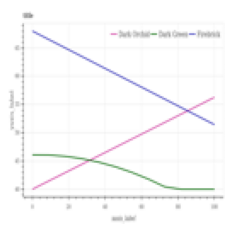

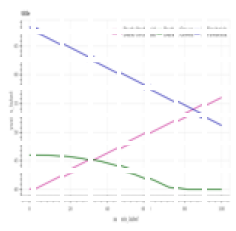

In [19]:
# Display the patches
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image/255)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)


patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy()/255)
    plt.axis("off")

In [20]:
# Patch encoding

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [21]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [22]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
    )

    history = model.fit(
        x_train, y_train_enc,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_validation, y_validation_enc),
    )

    return history, model


vit_classifier = create_vit_classifier()
history, model = run_experiment(vit_classifier)

Epoch 1/30
13/13 [==============================] - 15s 386ms/step - loss: 1.8146 - sparse_categorical_accuracy: 0.5612 - val_loss: 1.1559 - val_sparse_categorical_accuracy: 0.7850
Epoch 2/30
13/13 [==============================] - 4s 295ms/step - loss: 0.8995 - sparse_categorical_accuracy: 0.7862 - val_loss: 0.5639 - val_sparse_categorical_accuracy: 0.7950
Epoch 3/30
13/13 [==============================] - 4s 302ms/step - loss: 0.7528 - sparse_categorical_accuracy: 0.8112 - val_loss: 0.3790 - val_sparse_categorical_accuracy: 0.7950
Epoch 4/30
13/13 [==============================] - 4s 296ms/step - loss: 0.6400 - sparse_categorical_accuracy: 0.8150 - val_loss: 0.3246 - val_sparse_categorical_accuracy: 0.8150
Epoch 5/30
13/13 [==============================] - 4s 299ms/step - loss: 0.7592 - sparse_categorical_accuracy: 0.8062 - val_loss: 0.3541 - val_sparse_categorical_accuracy: 0.8150
Epoch 6/30
13/13 [==============================] - 4s 298ms/step - loss: 0.6117 - sparse_categoric

Let's plot the training and validation loss and Accuracy

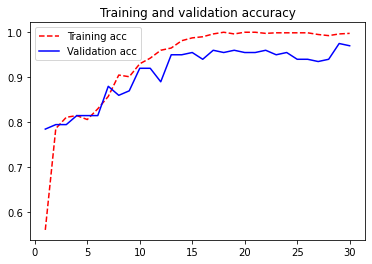

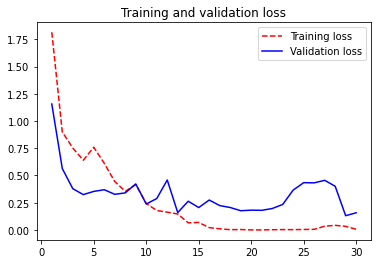

In [23]:
def plot_accuracy_and_loss(history):
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, '--r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs, loss, '--r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot_accuracy_and_loss(history)

Let's check predictions by the model on test set which is unlabelled data

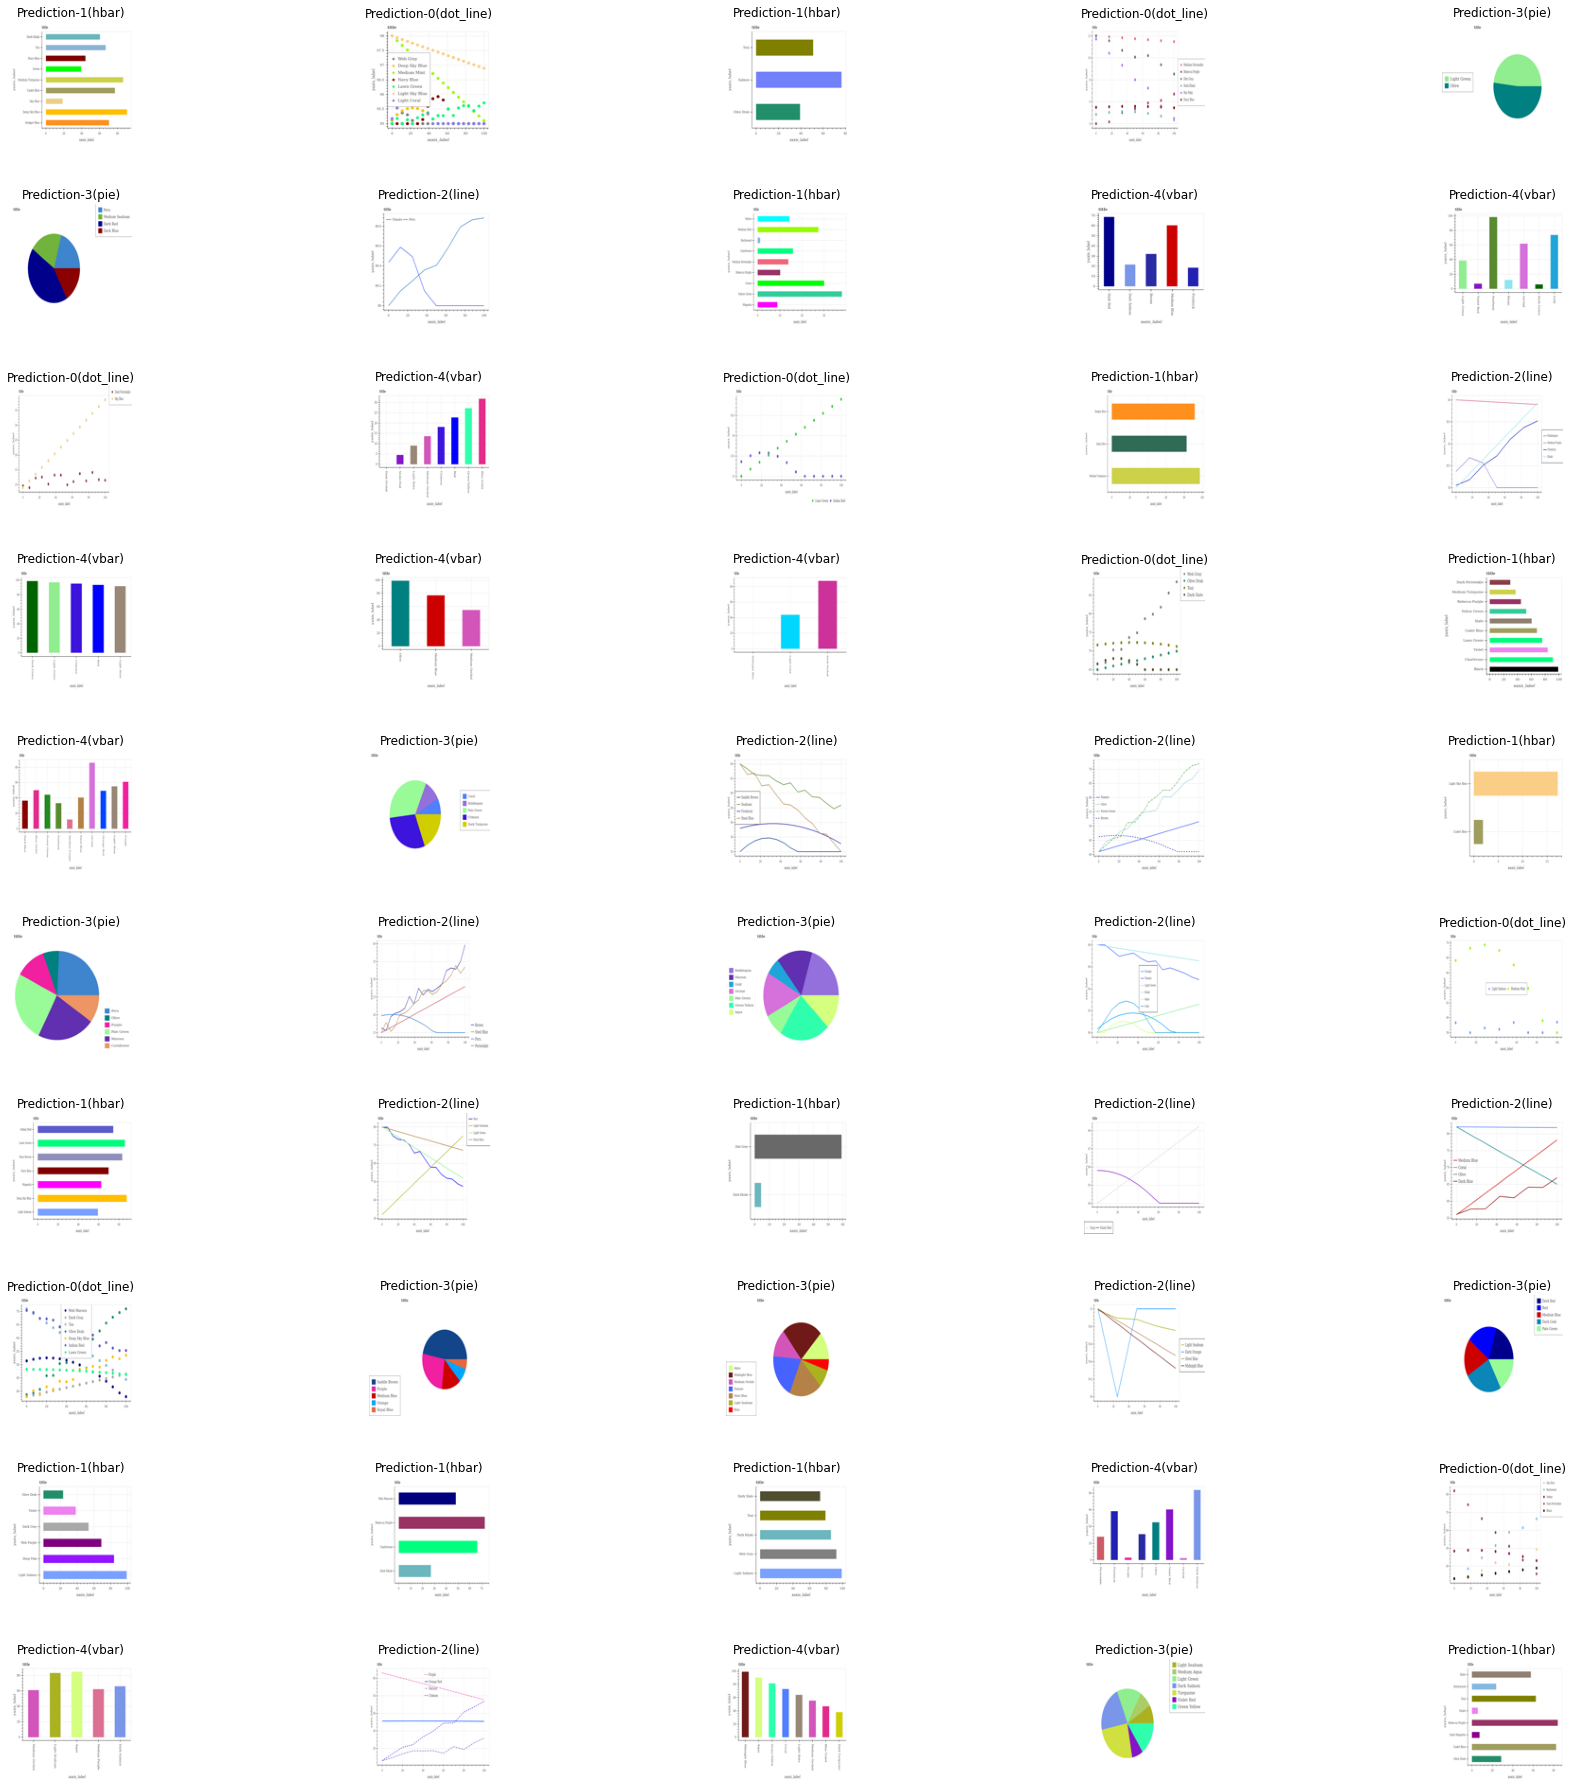

In [24]:
import numpy as np
prediction = model.predict(x_test)


fig, ax = plt.subplots(10, 5, figsize=(25,25))
fig.tight_layout(h_pad=4)
idx = 0
for i in range(0, 10):
    for j in range(0, 5):

        prediction_label = np.argmax(prediction[idx])
        ax[i][j].title.set_text('Prediction-{0}({1})'.format(prediction_label, Number(prediction_label).name))
        image = x_test[idx]
        ax[i][j].imshow(image)
        ax[i][j].axis("off")
        idx += 1 
plt.show()

Evaluating the model on training set to see how the model learnt

In [25]:
train_loss, train_acc = model.evaluate(x_train, y_train_enc)
print('Accuracy:', train_acc)
print('Loss: ', train_loss)

25/25 [==============================] - 2s 49ms/step - loss: 6.7247e-05 - sparse_categorical_accuracy: 1.0000
Accuracy: 1.0
Loss:  6.724704871885478e-05


looking at the confusion matrix where if model could learn to differtiate between all the categories

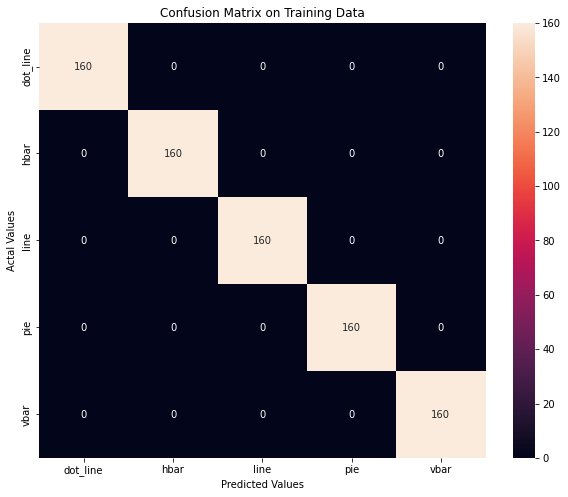

In [26]:
prediction = model.predict(x_train)
y_pred = [np.argmax(p) for p in prediction]

from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_pred, y_train_enc)

cm_df = pd.DataFrame(cm,
                     index = ['dot_line','hbar','line', 'pie', 'vbar'], 
                     columns = ['dot_line','hbar','line', 'pie', 'vbar'])

#Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix on Training Data')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

Evaluating the model on validation set which is labelled

In [27]:
val_loss, val_acc = model.evaluate(x_validation, y_validation_enc)
print('Accuracy:', val_acc)
print('Loss: ', val_loss)

7/7 [==============================] - 0s 51ms/step - loss: 0.1577 - sparse_categorical_accuracy: 0.9700
Accuracy: 0.9700000286102295
Loss:  0.15774177014827728


Checking how the confusion matrix looks like for validation data

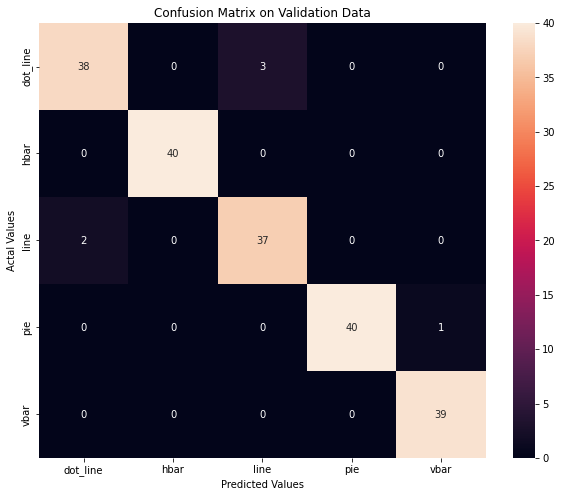

In [28]:
prediction = model.predict(x_validation)
y_pred = [np.argmax(p) for p in prediction]
cm = confusion_matrix(y_pred, y_validation_enc)

cm_df = pd.DataFrame(cm,
                     index = ['dot_line','hbar','line', 'pie', 'vbar'], 
                     columns = ['dot_line','hbar','line', 'pie', 'vbar'])

#Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix on Validation Data')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()